In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras import models

In [2]:
path="/Users/kimdaehyeok/Desktop/Classes/DL/BCI/"
epoch=1000

# Data Preprocessing

In [3]:
df = pd.read_csv('emotions.csv')
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [4]:
print(df.shape[0])
print(df.iloc[0,-1])

2132
NEGATIVE


In [5]:
for col in df.columns:
    if(df[col].isnull().sum()>0):
        print(col)


label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


<Axes: title={'center': 'Label'}, xlabel='label'>

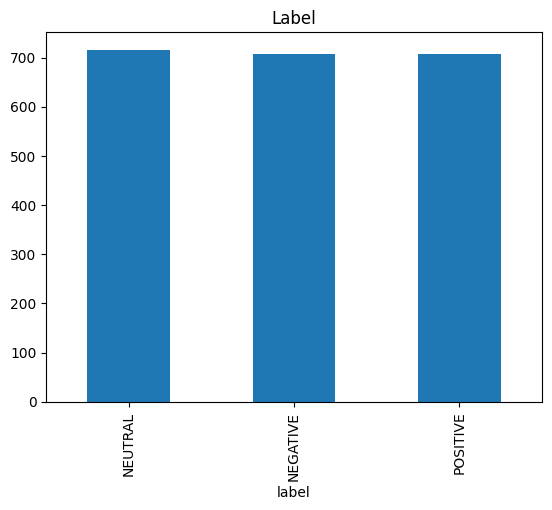

In [6]:
print(f'{df.label.value_counts()}')
df.label.value_counts().plot(kind='bar', color='tab:blue', title='Label')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


KeyboardInterrupt: 

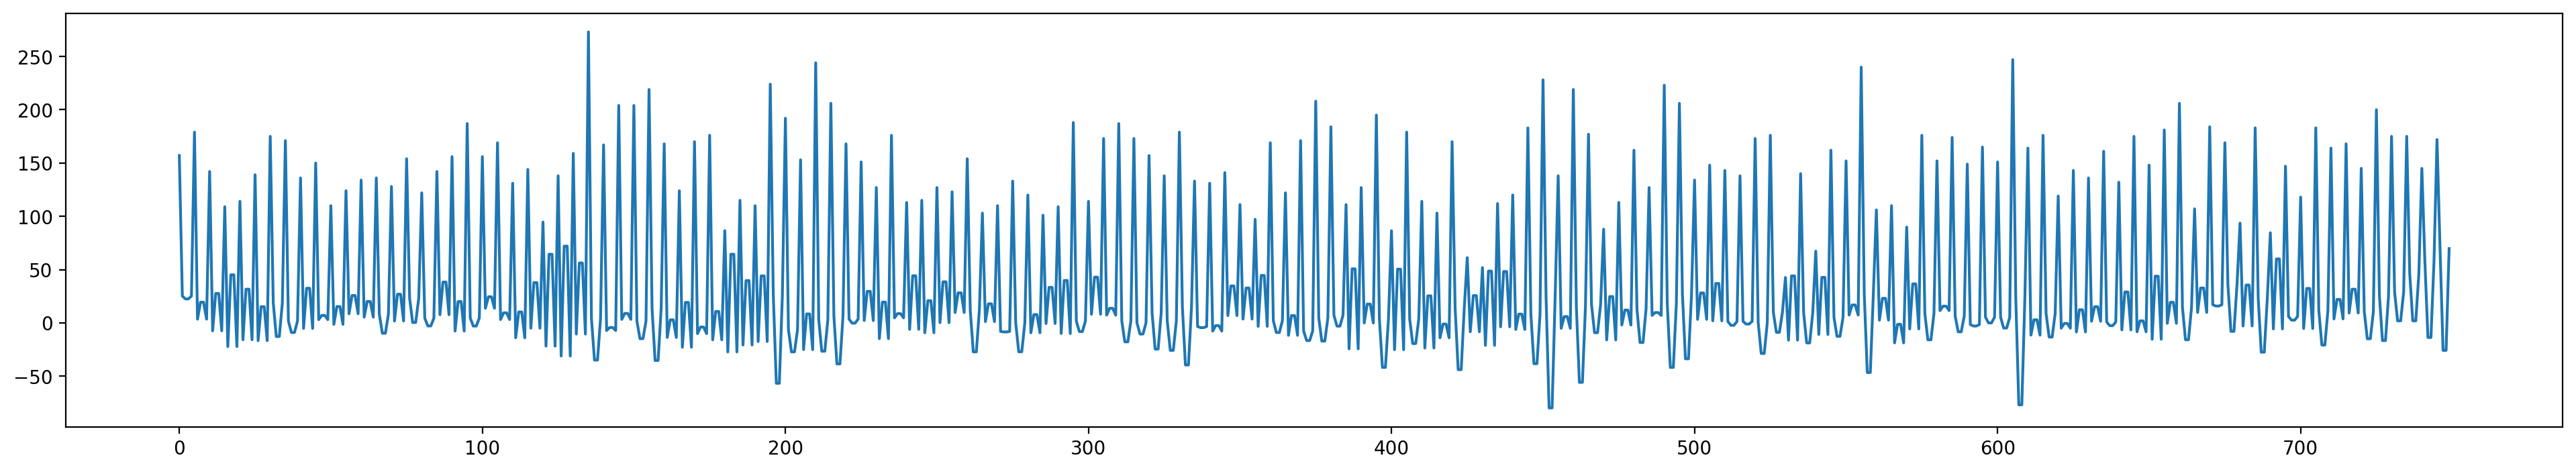

In [7]:
# CSV to image dataset
dataset_path=f"{path}imagedataset/"
for i in range(df.shape[0]):
    print(i)

    data = df.loc[i, 'fft_0_b':'fft_749_b']
    
    # x축 값으로 timestep을 사용
    timestep = range(len(data))  # timestep은 데이터의 길이에 맞게 설정

    # 그래프 그리기
    plt.figure(figsize=(24, 4), dpi=200)
    plt.plot(timestep, data)

    # 감정 정보 추출
    emotion = df.iloc[i, -1].upper()

    plt.savefig(f"{dataset_path}{i+1}_{emotion}.png")
    plt.close()



# ML prep.

In [8]:
emotion_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

# 이미지 경로와 감정 레이블을 리스트로 저장
image_paths = []
labels = []

image_dir = dataset_path  # 저장한 이미지 디렉토리 경로로 변경

# 이미지 파일 및 레이블 로드
for i, emotion in enumerate(df['label'].map(emotion_mapping)):  # 'emotion_column'을 실제 컬럼명으로 변경
    image_filename = f"{image_dir}{i+1}_{df.iloc[i, -1].upper()}.png"
    image_paths.append(image_filename)
    labels.append(emotion)

# 이미지를 로드하여 numpy 배열로 변환
image_size = (64, 64)  # 이미지 크기 조정
X = np.array([img_to_array(load_img(img, target_size=image_size)) for img in image_paths])
y = np.array(labels)

# 이미지 셔플
X, y = shuffle(X, y, random_state=123)

# Train, Test, Validation 분할 (7:2:1 비율)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)  # 7:3 비율
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=123)  # 2:1 비율

# 라벨을 one-hot 인코딩
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

OSError: image file is truncated

# CNN

In [ ]:
# CNN 모델 정의
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3개의 클래스
])

# CNN 모델 컴파일
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# CNN 모델 학습
cnn_history = cnn_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val))


Epoch 1/10


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5125 - loss: 137.0497 - val_accuracy: 0.8224 - val_loss: 0.4379
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8581 - loss: 0.3664 - val_accuracy: 0.8388 - val_loss: 0.4538
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8784 - loss: 0.3032 - val_accuracy: 0.8575 - val_loss: 0.4100
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8948 - loss: 0.2680 - val_accuracy: 0.8551 - val_loss: 0.4876
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9295 - loss: 0.1919 - val_accuracy: 0.8248 - val_loss: 0.6849
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9347 - loss: 0.1855 - val_accuracy: 0.8738 - val_loss: 0.3956
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9491 - loss: 0.1498 - val_accuracy: 0.8715 - val_loss: 0.4826
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9505 - loss: 0.1441 - val_accuracy: 0.8435 - val_loss: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8857 - loss: 0.3476 


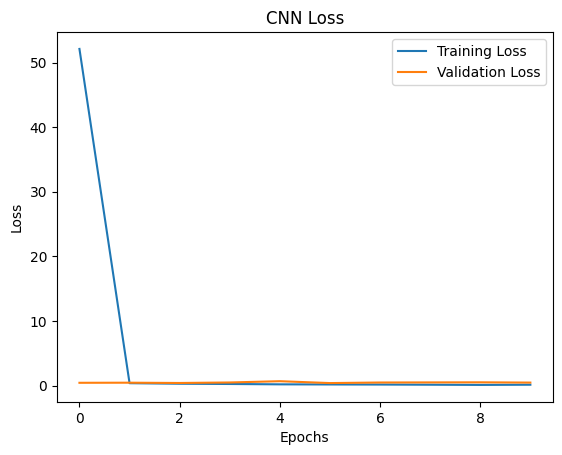

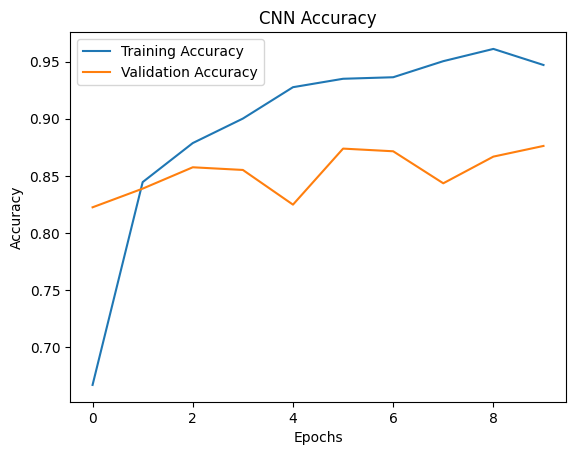

In [81]:
# loss, accuracy
print(cnn_history)
cnn_train_loss = cnn_history.history['loss'][-1]
cnn_train_accuracy = cnn_history.history['accuracy'][-1]
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test)
      
# visualize
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LSTM

In [ ]:
# LSTM 모델 정의 (이미지를 1D 배열로 변환하여 LSTM에 입력)
X_train_lstm = X_train.reshape((X_train.shape[0], -1))  # (samples, timesteps, features)
X_val_lstm = X_val.reshape((X_val.shape[0], -1))
X_test_lstm = X_test.reshape((X_test.shape[0], -1))

lstm_model = models.Sequential([
    layers.LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),  # 각 특성에 대해 LSTM 처리
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3개의 클래스
])

# LSTM 모델 컴파일
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# LSTM 모델 학습
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=1000, validation_data=(X_val_lstm, y_val))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8942 - loss: 0.6009 


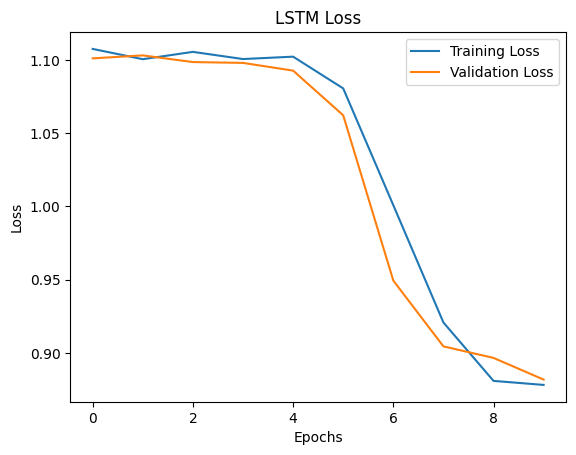

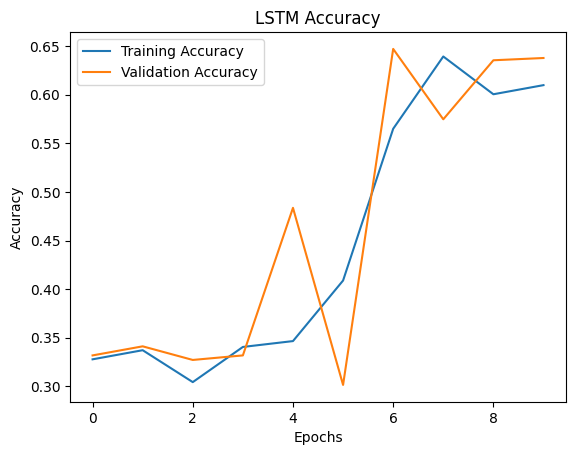

In [79]:
# loss, accuracy
print(lstm_history)
lstm_train_loss = lstm_history.history['loss'][-1]
lstm_train_accuracy = lstm_history.history['accuracy'][-1]
lstm_test_loss, lstm_test_accuracy = cnn_model.evaluate(X_test, y_test)
      
# visualize
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()